In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/furyhawk/text_summarization/raw/master'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

In [3]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates-blueprint.csv"
file = f"{BASE_DIR}/data/un-general-debates/un-general-debates.csv.zip" ### real location
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,text
3871,42,1987,HND,"﻿On behalf of the Government of Honduras I extend to you, Sir, sincere congratulations on your election as President of the forty-second session o..."
4697,35,1980,THA,﻿My delegation takes pleasure in extending to Mr. Riidiger von Wechmar its sincere congratulations on his unanimous election to the presidency of ...


## Load BBC News summary dataset

Check if dataset has already been saved, read from cvs if yes.

In [4]:
root_path = f'../data/BBC News Summary'


# root_path = f'/kaggle/input/bbc-news-summary/BBC News Summary'


def loadDataset(root_path):

    types_of_articles = ['business',
                         'entertainment', 'politics', 'sport', 'tech']
    df = pd.DataFrame(columns=['title', 'article', 'summary'])

    for type_of_article in types_of_articles:
        # type_of_article = 'business'  # entertainment, politices, sport, tech
        num_of_article = len(os.listdir(
            f"{root_path}/News Articles/{type_of_article}"))

        print(f'"Reading {type_of_article} articles"')
        dataframe = pd.DataFrame(columns=['title', 'article', 'summary'])

        for i in tqdm(range(num_of_article)):
            with open(f'{root_path}/News Articles/{type_of_article}/{(i+1):03d}.txt', 'r', encoding="utf8", errors='ignore') as f:
                article = f.read().partition("\n")
            with open(f'{root_path}/Summaries/{type_of_article}/{(i+1):03d}.txt', 'r', encoding="utf8", errors='ignore') as f:
                summary = f.read()

            dataframe.loc[i] = [article[0], article[2].replace(
                '\n', ' ').replace('\r', ''), summary]

        df = df.append(dataframe, ignore_index=True)

    return df


In [5]:
fname = 'bbc.csv'

if os.path.isfile(fname):
    df = pd.read_csv(fname)
else:
    df = loadDataset(root_path)
    df.to_csv(fname, index=False)

In [7]:
df['length'] = df['article'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,2225.00,2232.79,1364.25,471.00,1414.00,1936.00,2774.00,25454.00


In [8]:
df[['article', 'title', 'summary']].describe(include='O').T


,count,unique,top,freq
article,2225,2092,Microsoft has warned PC users to update their systems with the latest security fixes for flaws in Windows programs. In its monthly security bull...,2
title,2225,2096,Microsoft seeking spyware trojan,2
summary,2225,2081,"Although the two partially-paralysed people performed better overall, the researchers said this could be because their brains were more used to ad...",2


Check for NA value

In [9]:
df.isna().sum()

title      0
article    0
summary    0
length     0
dtype: int64

<AxesSubplot:>

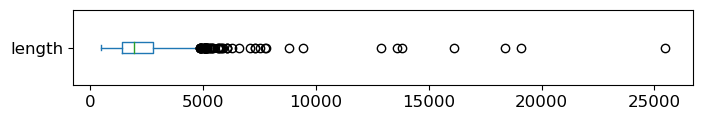

In [10]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

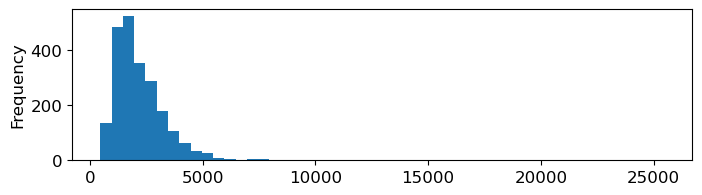

In [13]:
df['length'].plot(kind='hist', bins=50, figsize=(8,2))

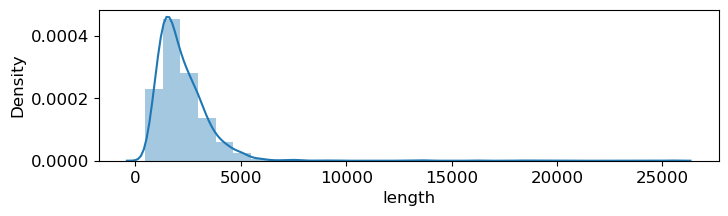

In [14]:
# seaborn plot with gaussian kernel density estimate
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.distplot(df['length'], bins=30, kde=True);

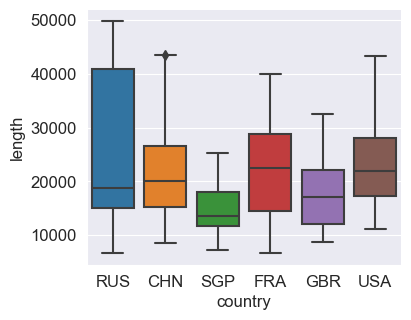

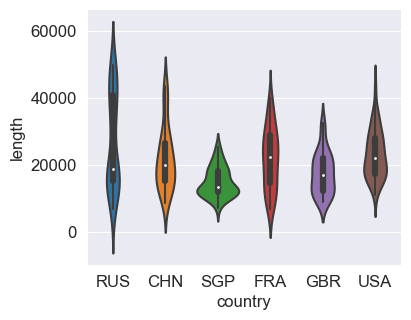

In [10]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS', 'SGP'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

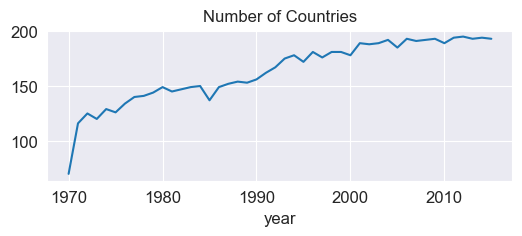

In [11]:
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,2))

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

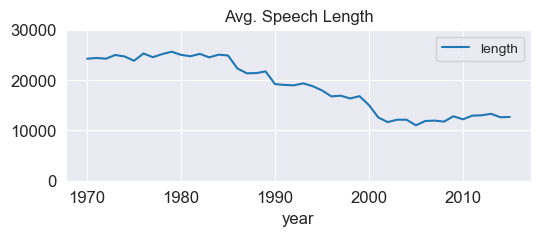

In [12]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

In [21]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [22]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\furyx\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [18]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [19]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [23]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [24]:
df['tokens'] = df['article'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 2225/2225 [00:01<00:00, 1483.10it/s]


In [25]:
df['num_tokens'] = df['tokens'].progress_map(len)

100%|██████████| 2225/2225 [00:00<00:00, 445350.82it/s]


In [26]:
from collections import Counter
counter = Counter()
_ = df['tokens'].map(counter.update)

pp.pprint(counter.most_common(50))

[('said', 7254),
 ('mr', 3005),
 ('people', 2041),
 ('new', 1901),
 ('us', 1818),
 ('year', 1815),
 ('one', 1757),
 ('could', 1496),
 ('last', 1375),
 ('first', 1273),
 ('two', 1176),
 ('world', 1166),
 ('government', 1152),
 ('time', 1141),
 ('uk', 1026),
 ('years', 998),
 ('against', 964),
 ('best', 920),
 ('make', 913),
 ('told', 910),
 ('get', 873),
 ('made', 855),
 ('game', 847),
 ('like', 838),
 ('many', 828),
 ('music', 812),
 ('film', 809),
 ('next', 775),
 ('labour', 766),
 ('three', 761),
 ('number', 753),
 ('bbc', 750),
 ('back', 742),
 ('added', 731),
 ('way', 723),
 ('take', 722),
 ('well', 701),
 ('set', 682),
 ('company', 681),
 ('may', 679),
 ('market', 671),
 ('says', 667),
 ('home', 641),
 ('good', 640),
 ('going', 624),
 ('still', 617),
 ('much', 609),
 ('party', 607),
 ('since', 606),
 ('games', 601)]


In [27]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [28]:
freq_df = count_words(df)


100%|██████████| 2225/2225 [00:00<00:00, 13907.13it/s]


In [29]:
freq_df.head(60)

,freq
token,
said,7254
mr,3005
people,2041
new,1901
us,1818
year,1815
one,1757
could,1496
last,1375


In [31]:
# top words with 10+ characters
count_words(df, column='article', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

100%|██████████| 2225/2225 [00:00<00:00, 2566.87it/s]


,freq
token,
government,1110
technology,536
information,328
international,245
performance,229


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

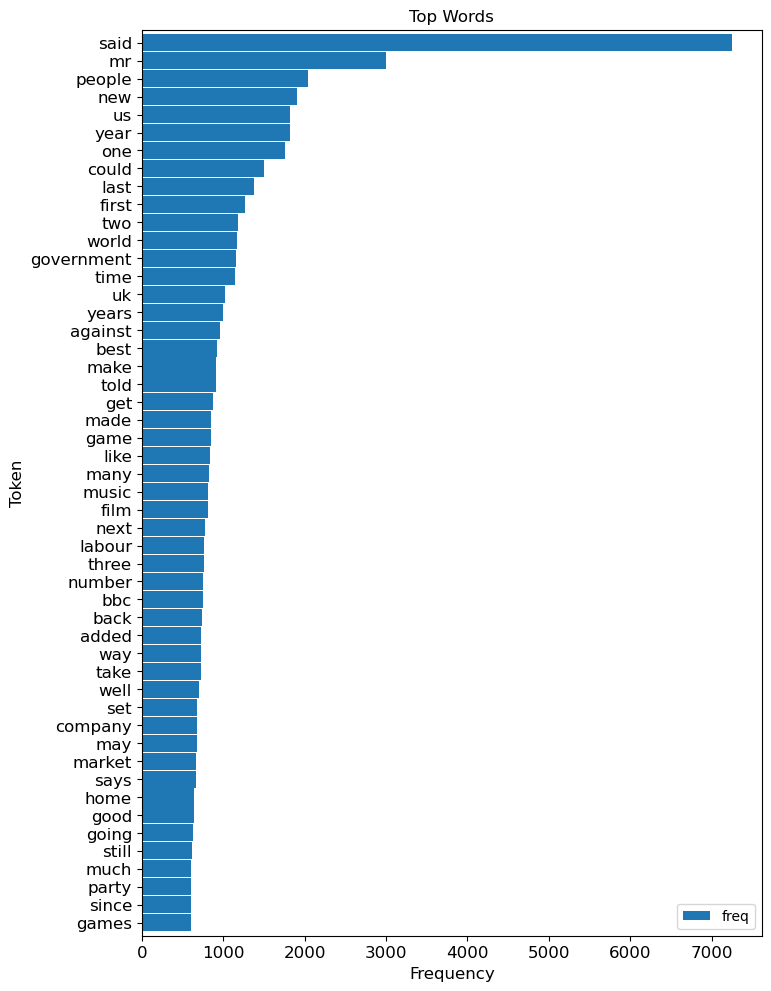

In [32]:
ax = freq_df.head(50).plot(kind='barh', width=0.95, figsize=(8,12))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

In [42]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = freq_df #['token']
text.head
# plt.figure(figsize=(15, 12)) ###
# wc = WordCloud(max_words=100, stopwords=stopwords)
# wc.generate(text)
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")

<bound method NDFrame.head of           freq
token         
said      7254
mr        3005
people    2041
new       1901
us        1818
...        ...
artistry     2
eaa          2
frances      2
widowed      2
alot         2

[19644 rows x 1 columns]>

In [30]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

  0%|          | 0/193 [00:00<?, ?it/s]

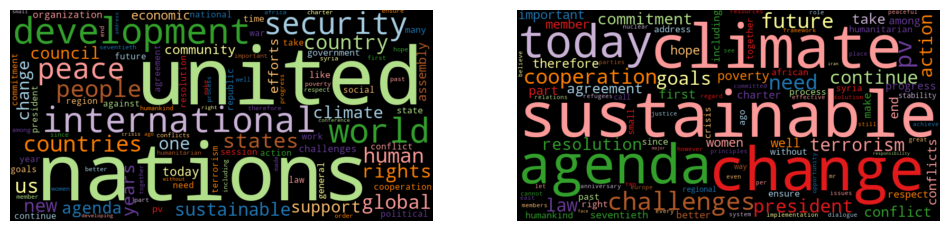

In [31]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

In [32]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [33]:
idf_df = compute_idf(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [35]:
# Not in book: sample of IDF values
# high IDF means rare (interesting) term
idf_df.sample(5)

,df,idf
token,,
misgivings,62,4.90
measurably,4,7.64
non-cooperation,5,7.41
shelve,2,8.33
russian-ukrainian,2,8.33


In [36]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [37]:
# for more data: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

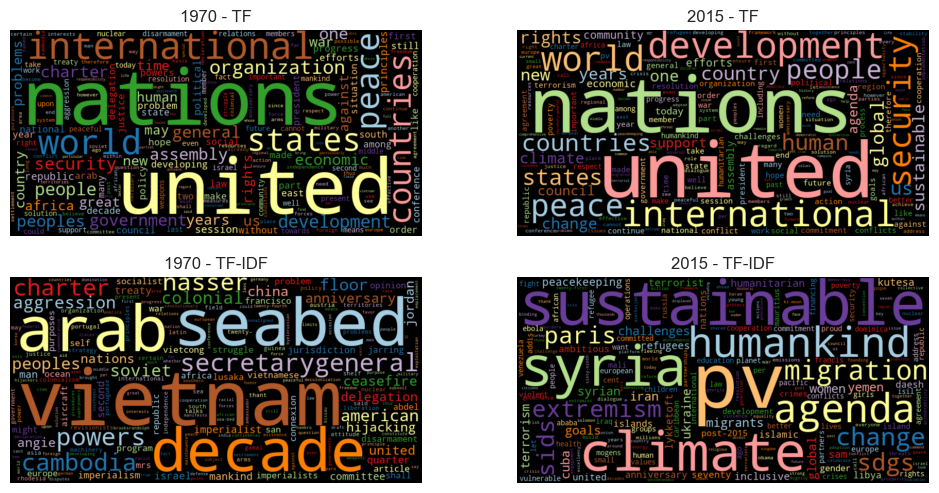

In [38]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

In [39]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [40]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [41]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

  0%|          | 0/193 [00:00<?, ?it/s]

5 random samples out of 73 contexts for 'sdgs':
ill vivid in our memories. The new   SDGs   framework must ensure that account
the Sustainable Development Goals (  SDGs  ). In other words, it is addressing
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
r Sustainable Development with its   SDGs   (resolution 70/1) requires us to d
 of Sustainable Development Goals (  SDGs  ). Given the ambition reflected in 


In [42]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [43]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [44]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [45]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

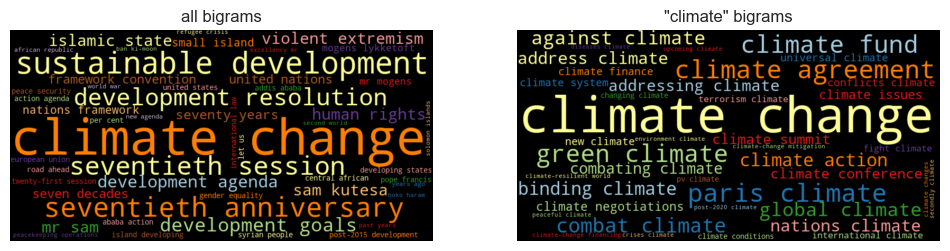

In [46]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

In [47]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [48]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [49]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [50]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [51]:
pd.options.display.max_rows = 4

In [52]:
pd.options.display.max_rows = 60

<AxesSubplot:xlabel='year'>

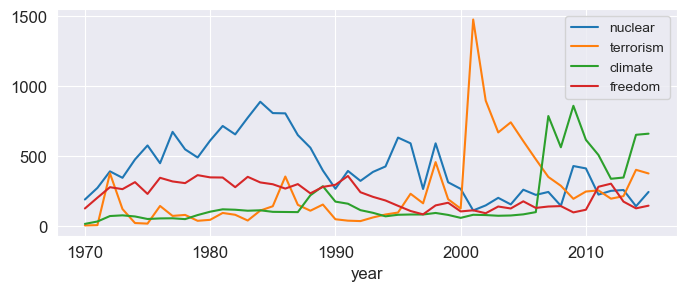

In [53]:
freq_df.plot(kind='line', figsize=(8, 3))

In [54]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

  0%|          | 0/1245 [00:00<?, ?it/s]

5 random samples out of 581 contexts for 'climate':
ncerned to foster an international   climate   that is conducive to the relaxatio
 to bring about a better political   climate   in the country or its responsibili
cold war. Changes in the political   climate   in Berlin and improvements in the 
e, the opposition is maintaining a   climate   of constant agitation while the Ro
we must try to create a favourable   climate   for co-operation among States, and


  0%|          | 0/7507 [00:00<?, ?it/s]

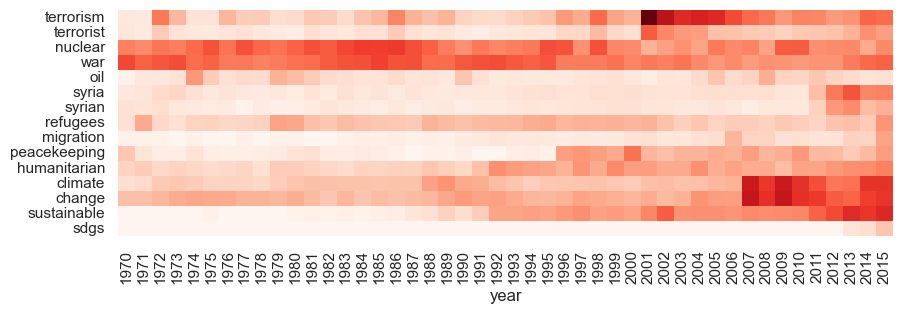

In [55]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###